In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import probplot

from stats import d2, D3, D4
from stats import XMR

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Guess the Process, Moving Range Charts

One of the easiest ways to start monitor a process is a moving range chart, especially if you have no prior data or knowledge of a process. Besides that, many processes do not allow for grouping up results for samples, so single measurements are the natural way to track it. Moving range charts are also used in many complicated processes as one part of their process control. It is also an introduction to more complicated charting like EWMA, or feedback in engineering control.

Even though there are lots of software packages that can be used to do calculations for control charting, it is very straight forward to implement yourself. See this small repository I made with some code to create moving range charts. The repository also goes into some more details about the charting and the data.

The control limits for the $X$ chart are calculated as followed:
$$ \overline{X} = \frac{\sum_{i=1}^n{x_i}}{n} $$
$$ UCL = \overline{X} + 3 \frac{\overline{MR}}{d_2} $$
$$ LCL = \overline{X} - 3 \frac{\overline{MR}}{d_2} $$

Here $x_i$ are the measurement values, $d_2=1.128$ is a statistical constant, the center line is given by $\overline{X}$, the upper control limit line has value $UCL$ and lower control limit line has value $LCL$. Below it shows how to calculate $\overline{MR}$ and the control limits for the $MR$ chart. 
$$ \overline{MR} = \frac{\sum_{i=2}^n{MR_i}}{n-1} $$
$$ MR_i=|x_i-x_{i-1}| $$
$$ UCL = D_4 \overline{MR} $$
$$ LCL = D_3 \overline{MR} $$

$D_3=0$, and $D_4=3.267$ are statistical constants.

In [2]:
df = pd.read_csv('data.csv')
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

In [3]:
xmr_A = XMR(df['A'].values, index=df['date'].values)
xmr_B = XMR(df['B'].values, index=df['date'].values)

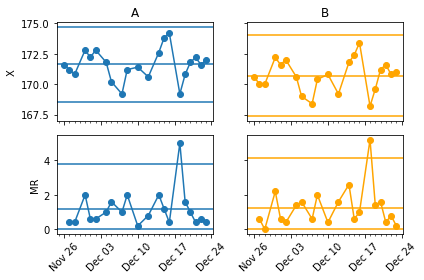

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey='row', tight_layout=True)
ax = axes.flatten()

xmr_A.xchart(ax[0])
xmr_A.mrchart(ax[2])
xmr_B.xchart(ax[1], color='orange')
xmr_B.mrchart(ax[3], color='orange')

ax[0].xaxis.set_major_locator(mdates.WeekdayLocator()) # major ticks every start of week
ax[0].xaxis.set_minor_locator(mdates.DayLocator()) # minor ticks every day
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax[2].get_xticklabels(), rotation=45)
plt.setp(ax[3].get_xticklabels(), rotation=45)
ax[0].set_ylabel('X')
ax[2].set_ylabel('MR')
ax[0].set_title('A')
ax[1].set_title('B')

plt.show()

The charts above are two control charts, named A and B, that follow the same process, with measurements done almost daily. I've set up the control charts next to each other and used the same ranges for the vertical and horizontal axes so it is easier to compare. Both charts behave the same, this is more clear by plotting them in the same figure.

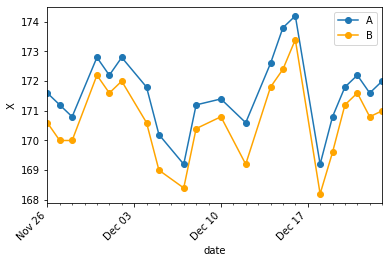

In [5]:
axes = df.plot(x='date', y='A', marker='o', )
df.plot(x='date', y='B', marker='o', ax=axes, color='orange')

axes.legend()
axes.xaxis.set_major_locator(mdates.WeekdayLocator()) # major ticks every start of week
axes.xaxis.set_minor_locator(mdates.DayLocator()) # minor ticks every day
axes.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(axes.get_xticklabels(), rotation=45)
axes.set_ylabel('X')

plt.show()

At the moment the amount of data is still quite limited, so I won't discuss in or out of control conditions until I get to update the figures with some more data. 

Here is the main question though:
 - What process do you think these charts are tracking?

Post your answer in the comment, or ask questions for hints.

Lastly, another way to use the moving range chart is to monitor the measurement system for consistency. In about 2 weeks I should have enough data to show the results for the measurement sysem used to monitor the process above.

In [6]:
df.loc[1:, 'MR A'] = xmr_A.data_mr
df.loc[1:, 'MR B'] = xmr_B.data_mr

df

,date,A,B,MR A,MR B
0,2019-11-26,171.6,170.6,NaN,NaN
1,2019-11-27,171.2,170.0,0.4,0.6
2,2019-11-28,170.8,170.0,0.4,0.0
3,2019-11-30,172.8,172.2,2.0,2.2
4,2019-12-01,172.2,171.6,0.6,0.6
5,2019-12-02,172.8,172.0,0.6,0.4
6,2019-12-04,171.8,170.6,1.0,1.4
7,2019-12-05,170.2,169.0,1.6,1.6
8,2019-12-07,169.2,168.4,1.0,0.6
9,2019-12-08,171.2,170.4,2.0,2.0


Most standard control charting depend on the data being normally distributed. Even with this quite limited data set we can get a good idea with a quantile plot. 

To create the quantile plots for A and B above I used the scipy.stats packages. The probplot function by default compares it to quantiles from the standard normal distribution. If the data is has a normal distribution it should show up as a straight line. Both follow a straight line, so there doesn't seem to be any issue assuming normally distributed data at this moment. 

You can get an estimate for the average value from the point where the theoretical quantile is equal to 0. From the slope you can get an estimate of the standard deviation. You can compare these values with those calculated from the data directly.

,A,B,MR A,MR B
count,21.000000,21.000000,20.00000,20.000000
mean,171.619048,170.704762,1.16000,1.260000
std,1.275782,1.347025,1.08113,1.171773
min,169.200000,168.200000,0.20000,0.000000
25%,170.800000,170.000000,0.40000,0.550000
50%,171.600000,170.800000,0.90000,0.900000
75%,172.200000,171.600000,1.60000,1.600000
max,174.200000,173.400000,5.00000,5.200000


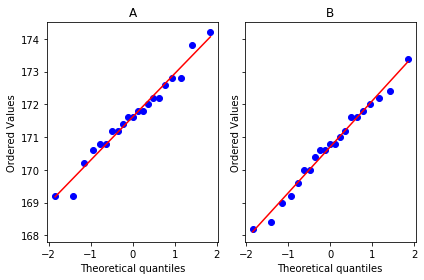

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, tight_layout=True)
axes = axes.flatten()

probplot(df['A'], plot=axes[0])
axes[0].set_title('A')
probplot(df['B'], plot=axes[1])
axes[1].set_title('B')

df.describe()

Text(0.5, 1.0, 'MR B')

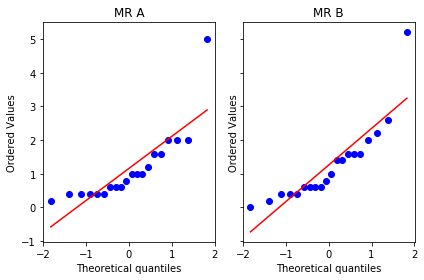

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, tight_layout=True)
axes = axes.flatten()

results = probplot(df['MR A'][1:], plot=axes[0])
axes[0].set_title('MR A')
probplot(df['MR B'][1:], plot=axes[1])
axes[1].set_title('MR B')